# PART II : Codes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Loading the Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/pd_speech_features.csv')

In [4]:
data

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.265120,0.083127,...,0.071728,0.010352,-2.730300,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.220040,0.127410,...,0.729330,0.780410,5.229400,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.157560,0.116890,...,0.269510,-0.005522,0.350540,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.172950,0.147370,...,0.366920,-0.492650,0.191640,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.0295,2.0362,1.8478,2.5776,2.2064,1.9491,1.9120,1.8829,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4

## Train Test Split
#### In this part:
 

*   We dropeed the id column from the training data because it won't be of any help in classification task.
*   We splitted the data in two parts: We used 80% of data for training and 20% of data for testing. Also we used sklearn stratify utility in train_test_split to ensure that relative class frequencies are approximately preserved in train and validation sets. We use stratified train test split to have the same distribution of classes in each split as the whole dataset.

In [ ]:
X = data.drop(columns=['class', 'id'])
y = data['class'].to_numpy()

In [ ]:
classes = np.unique(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X = X.to_numpy()

## Preprocess


### Scaling the data
#### We normalized the data so that every feature has mean zero and same range of variance. Sometimes there are features which have a large range and some features which have a small range but we don't want the later to have less impact than the first hence using normalization.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Imbalanced Data
#### Because the number of samples of the two classes was noticeably different, so at first we decided to use oversampling to overcome this issue. Imbalance training set results in unreliable performance results. For oversampling we used SMOTE(Synthetic Minority Over-sampling Technique) which adds new points to the dataset as follows: It takes a sample point and then finds it’s k neighbors. Then it finds the vector between one of those neighbors and the chosen sample. Then it multiples this vector with a number between 0 and 1 and at last it adds this vector to the sample point and obtains a new point.

We used the mentioned metrics to deal with the imbalance of data.

In [ ]:
def plot_balance(y):
  counts = np.unique(y, return_counts=True)
  plt.bar(counts[0], counts[1], tick_label=['class 0', 'class 1']);
  plt.title('count of classes')
  plt.xlabel('class')
  plt.ylabel('count');

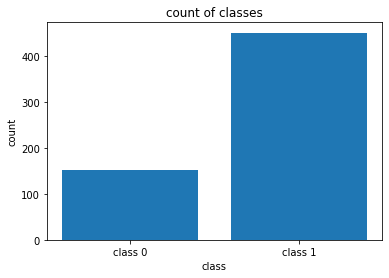

In [ ]:
plot_balance(y_train)

In [ ]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)

# counter = Counter(y_train)
# print(counter)

We decided not to use oversampling because it equalizes the prior class probabilities which is not desirable in bayes classification. Also in practive we tested this method and saw that it is better not to balance the initial dataset.

Another workaround to deal with imbalanced data is to use metrics like precision, recall and F1 score because they are not prune to the data imbalance effects. Recall measures how much of the true positive data are actually predicted positive. Precision measures how much of the points which are predicted as positive are actually positive. F1 score is a combination of these two metrics. Another method to deal with imbalance data is to assign different weights to the different classes in order to compensate with the inequality of the number of samples of the classes.

Also ROC curve which measures the model's ability to discriminate the positive class data from the rest is another way to deal with the imbalanced data. ROC curve considers the imbalance of the data and hence it will be usefull in model performance evaluation and model result comparisons. To compare by ROC curve we use Area Under ROC curve(AUC).

#Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix, roc_curve, auc

def plot_roc(clf, X_test, y_test):
  plt.figure() 
  y_pred = clf.predict(X_test)
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='(AUC={})'.format(round(roc_auc, 2)))
  plt.plot([0, 1], [0, 1], '--')
  plt.suptitle('roc curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right");

def report_results(clf, X_train, y_train, X_test, y_test):
  pred_train = clf.predict(X_train)
  print('################################################')
  print('Accuracy for train set = ', round(clf.score(X_train, y_train) * 100, 1), '%')
  print('################################################')
  print(classification_report(y_train, pred_train))
  print('################################################')
  disp = plot_confusion_matrix(clf, X_train, y_train, values_format = '.5g')
  disp.figure_.suptitle("Confusion Matrix")
  print("Confusion matrix:\n%s" % disp.confusion_matrix)
  plot_roc(clf, X_train, y_train)

  pred_test = clf.predict(X_test)
  print('################################################')
  print('Accuracy for test set = ', round(clf.score(X_test, y_test) * 100, 1), '%')
  print('################################################')
  print(classification_report(y_test, pred_test))
  print('################################################')
  disp = plot_confusion_matrix(clf, X_test, y_test, values_format = '.5g')
  disp.figure_.suptitle("Confusion Matrix")
  print("Confusion matrix:\n%s" % disp.confusion_matrix)
  plot_roc(clf, X_test, y_test)

Below is the function to run k-fold evaluation. Later in the classification we see the in some parts, the result of the simple train-test split is different from the result of k-fold. This is because of the different random states.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import warnings

def f1_score(precision, recall):
  return (2 * (precision * recall)) / (precision + recall)

def rd(x):
    return round(x, 4)

def kfold_results(clf, X, y, k=5):
 
  kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
  accuracies, recalls, precisions, f1_scores = [], [], [], []
  for train_ix, test_ix in kfold.split(X, y):

    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]

    #scaling the data
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)

    # oversample = SMOTE()
    # with warnings.catch_warnings():
	    # ignore all caught warnings
      # warnings.filterwarnings("ignore")
      # train_X, train_y = oversample.fit_resample(train_X, train_y)

    #feature reduction
    pca = PCA(n_components=new_features, whiten=must_withen)
    pca.fit(train_X)
    train_X = pca.transform(train_X)
    test_X = pca.transform(test_X)

    clf.fit(train_X, train_y)
    test_pred = clf.predict(test_X)
    train_pred = clf.predict(train_X)
    accuracies.append([accuracy_score(test_y, test_pred), accuracy_score(train_y, train_pred)])
    recalls.append([recall_score(test_y, test_pred, average='weighted'), recall_score(train_y, train_pred)])
    precisions.append([precision_score(test_y, test_pred, average='weighted'), precision_score(train_y, train_pred, average='weighted')])
    f1_scores.append([f1_score(precision_score(test_y, test_pred, average='weighted'),recall_score(test_y, test_pred, average='weighted')), f1_score(precision_score(train_y, train_pred, average='weighted'),recall_score(train_y, train_pred, average='weighted'))])
  


  print('Train set results: \n')
  print(f'Mean Accuracy: {rd(np.mean(np.array(accuracies)[:,1]))},\t Accuracy Variance:{rd(np.var(np.array(accuracies)[:,1]))}')
  print(f'Mean Recall: {rd(np.mean(np.array(recalls)[:,1]))},\t Recall Variance:{rd(np.var(np.array(recalls)[:,1]))}')
  print(f'Mean Precision: {rd(np.mean(np.array(precisions)[:,1]))},\t Precision Variance:{rd(np.var(np.array(precisions)[:,1]))}')
  print(f'Mean F1 Score: {rd(np.mean(np.array(f1_scores)[:,1]))},\t F1 Score Variance:{rd(np.var(np.array(f1_scores)[:,1]))}')
  print("\n#########################################\n")
  print('Test set results: \n')
  print(f'Mean Accuracy: {rd(np.mean(np.array(accuracies)[:,0]))},\t Accuracy Variance:{rd(np.var(np.array(accuracies)[:,0]))}')
  print(f'Mean Recall: {rd(np.mean(np.array(recalls)[:,0]))},\t Recall Variance:{rd(np.var(np.array(recalls)[:,0]))}')
  print(f'Mean Precision: {rd(np.mean(np.array(precisions)[:,0]))},\t Precision Variance:{rd(np.var(np.array(precisions)[:,0]))}')
  print(f'Mean F1 Score: {rd(np.mean(np.array(f1_scores)[:,0]))},\t F1 Score Variance:{rd(np.var(np.array(f1_scores)[:,0]))}')
  

# Feature Engineering
#### Here we try dimmensionality reduction methods to reduce number of features. Notice that we commented the methods which are not used at the end.

### PCA
#### Because the number of features are very high(almost equal to the size of the dataset), we must use dimensionality reduction to avoid overfitting. For this purpose we tested different algorithms like LDA, ICA and autoEncoder and we saw that PCA without withenning has better results. Whitening helps to de-correlate the features and make the covariance matrix correspond to a sphere, but also removes some information(the relative variance scales of the components) from the transformed signal and hence sometimese may result in a worse performance than the case where we do not whiten the dataset so we decided not to whiten the data.  With PCA we can choose principal directions of data such that it covers high variance of data. We choose as many features to cover a suitable variance ratio of data. We tried many numbers as the size of the new dimmension and finally we concluded that using around 41 features results in a better performance.


Below, first we plot the accumulative explained variance diagram w.r.t. the number of features, used. We can see that in order to

In [ ]:
from sklearn.decomposition import PCA

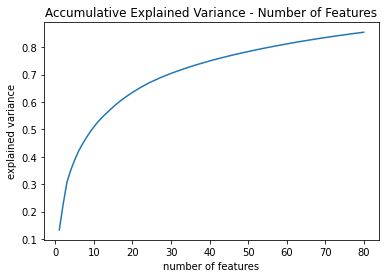

In [ ]:
m = 80
must_withen = False

explained_vars = []
pca = PCA(n_components=m, whiten=must_withen)
pca.fit(X_train)

for i in range(1, m+1):
  explained_vars.append(np.sum(pca.explained_variance_ratio_[:i]))

plt.plot(np.arange(1, m+1), explained_vars)

plt.xlabel('number of features')
plt.ylabel('explained variance');
plt.title('Accumulative Explained Variance - Number of Features');

In [ ]:
new_features = 80
pca = PCA(n_components=new_features, whiten=must_withen)
pca.fit(X_train)
print('explained variance = ', pca.explained_variance_ratio_.sum())

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

explained variance =  0.854690342940651


### LDA
#### In contrast to PCA, LDA is a supervised algorithm which tries to maximize the discriminability of the classes and not the explained variance. But as it was limited only to one feature(number of classes - 1) it didn’t have a good performance on models.


In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda = LinearDiscriminantAnalysis(n_components=1)
# lda.fit(X_train_pca, y_train)

# X_train_lda = lda.transform(X_train_pca)
# X_test_lda = lda.transform(X_test_pca)

### ICA
#### ICA is an unsupervised algorithm which aims to find vectors which are independent. For example for a mixture of signals it tries to find the base signals. PCA had better results that ICA so we didn't use ICA.

In [ ]:
# from sklearn.decomposition import FastICA
# ica = FastICA(n_components=60, random_state=0, whiten=True)
# X_train_ica = ica.fit(X_train)
# X_train_ica = ica.transform(X_train)
# X_test_ica = ica.transform(X_test)

## AutoEncoder
#### For implementing auto-encoder we used keras library which is a very popular library for neural networks applications. We constructed a model with 1 hidden layer for the encoder and 1 hidden layer for the decoder. Encoder is the first part of auto-encoder which makes the lower-dimensional representation of the input. Decoder is the second part of the auto-encoder which reconstructs the input from the lower-dimensional representation. We set the number of neurons of the last layer of the encoder to be 50 which is the new number of the features.

In [ ]:
# import keras
# from keras import layers

# def autoEncoder(X_train):
#   encoding_dim = 50  
#   feature_dim = X_train.shape[1]
#   input = keras.Input(shape=(feature_dim,))
#   encoded = layers.Dense(encoding_dim, activation='relu')(input)
#   decoded = layers.Dense(feature_dim, activation='sigmoid')(encoded)
#   autoencoder = keras.Model(input, decoded)
#   encoder = keras.Model(input, encoded)
#   encoded_input = keras.Input(shape=(encoding_dim,))
#   decoder_layer = autoencoder.layers[-1]
#   decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

#   autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#   autoencoder.fit(X_train, X_train,
#                 epochs=50,
#                 batch_size=256,
#                 shuffle=True,
#                 verbose=0)

#   return encoder

## Backward Elimination

#### Since **Backward Elimination** algorithm is specific to the classifier used, here we will be using KNN to examine the effectiveness of this feature reduction technique. However, since there are more than 700 features and running the algorithm for this many features will be very time consuming we will first use PCA to select 200 features and use backward elimination to reduce those 200 to 100 features. As this technique takes a very long time we have not used it for other classifiers.



In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=200, whiten=False)
# pca.fit(X_train)
# X_train_pca_for_backward = pca.transform(X_train)
# X_test_pca_for_backward = pca.transform(X_test)

# X_train_pca_for_backward.shape

(604, 200)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.feature_selection import SequentialFeatureSelector

# clf = KNeighborsClassifier(n_neighbors=3)
# sbs = SequentialFeatureSelector(clf, n_features_to_select=100, direction='backward')
# X_train_sbs = sbs.fit_transform(X_train_pca_for_backward, y_train)
# X_test_sbs = sbs.transform(X_test_pca_for_backward)
# X_train_sbs.shape

# clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

################################################
Accuracy for train set =  95.4 %
################################################
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       153
           1       0.95      0.98      0.97       451

    accuracy                           0.95       604
   macro avg       0.95      0.92      0.94       604
weighted avg       0.95      0.95      0.95       604

################################################
Confusion matrix:
[[132  21]
 [  7 444]]
################################################
Accuracy for test set =  89.5 %
################################################
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        39
           1       0.91      0.96      0.93       113

    accuracy                           0.89       152
   macro avg       0.88      0.84      0.85       152
weighted avg       0.89      0.89      0.89       

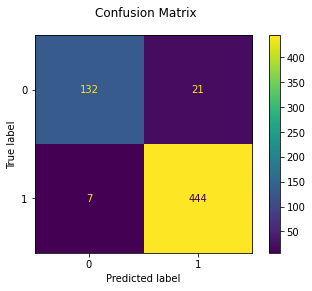

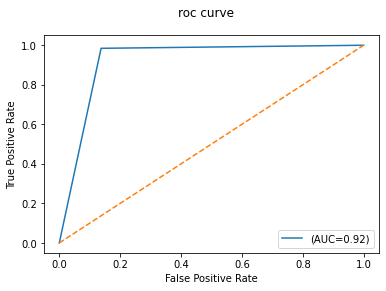

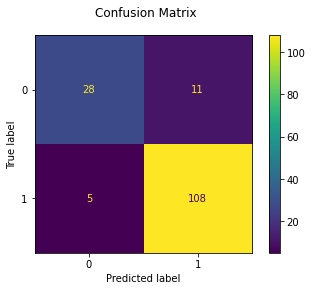

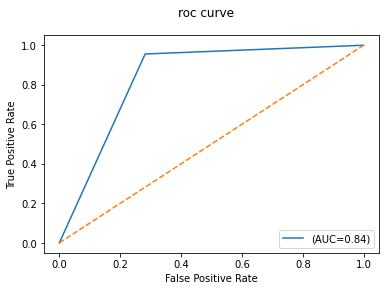

In [ ]:
# report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
X_train, X_test = X_train_pca, X_test_pca
# X_train, X_test = X_train_lda, X_test_lda
# X_train, X_test = X_train_ica, X_test_ica
# X_train, X_test = X_train_ica, X_test_ica

# encoder = autoEncoder(X_train)
# X_train = encoder.predict(X_train)
# X_test = encoder.predict(X_test)

# Classification

## Generative Classifiers
#### In generative models, we model the distributions of individual classes and how the data is actually generated from the inputs. These kinds of models learn the joint probability distribution of data and classes, as opposed to discriminative algorithms which try to find the conditional probability classes and data.

## Discriminative Classifiers
#### In discriminative models, the conditional probability is estimated and classification is based on that probability.

#### One advantage of Discriminative Classifiers is that they need less data than Generative Classifiers because Generatives find the joint distributions. Also Generative models are more sensitive to outliers because the outliers potentially affect the distribution greatly. Furthurmore Generative models are also more computationally expensive than discriminative models and hence consume more power and time. 

# Parametric vs Non-Parametric
#### Parametric Classifiers like logistic regression assumes a distribution shape for data so the configuration space is small. But non-parametric Classifiers doesn't assume anything about data. Parametric Classifiers need to only find some parameters so they are trained and then they don't need the data, hence they are more memory efficient. Non-parametric ones can model more complex distributions and have less bias.

# Generative Classifiers

## Gaussian Mixture Model

### A Gaussian mixture model has a  probabilistic view and assumes all the data points are generated from a mixture of some Gaussian distributions which have unknown parameters. We first found the densities and then applied the bayes optimal classification.

################################################
Accuracy for train set =  97.0 %
################################################
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       153
           1       1.00      0.96      0.98       451

    accuracy                           0.97       604
   macro avg       0.95      0.98      0.96       604
weighted avg       0.97      0.97      0.97       604

################################################
Confusion matrix:
[[152   1]
 [ 17 434]]
################################################
Accuracy for test set =  78.3 %
################################################
              precision    recall  f1-score   support

           0       0.59      0.49      0.54        39
           1       0.83      0.88      0.86       113

    accuracy                           0.78       152
   macro avg       0.71      0.69      0.70       152
weighted avg       0.77      0.78      0.78       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


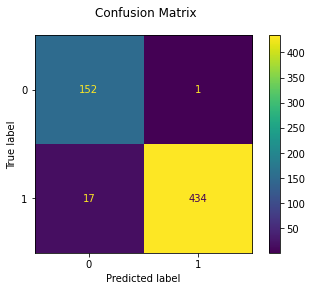

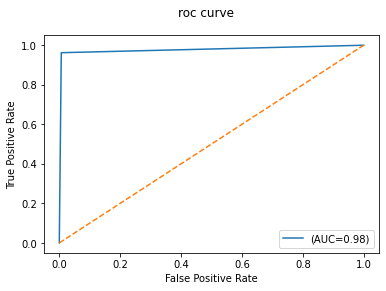

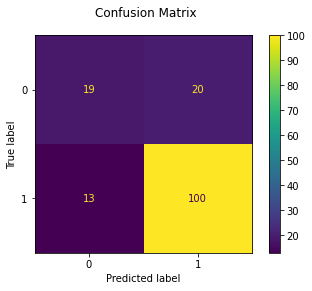

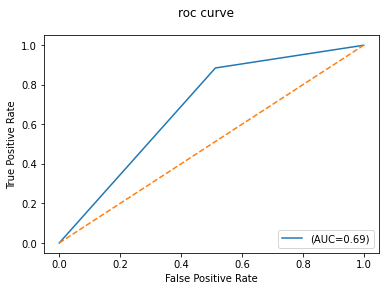

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

def plot_gmm_roc(true, pred):
  plt.figure() 
  fpr, tpr, _ = roc_curve(true, pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='(AUC={})'.format(round(roc_auc, 2)))
  plt.plot([0, 1], [0, 1], '--')
  plt.suptitle('roc curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right");


class GMMClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self):
    self.models = []
    self.logpriors = []
    self.classes_ = None

  def fit(self, X_train, y_train):
    self.__init__()
    self.logpriors = []
    self.classes_ = np.unique(y_train)
    for c in self.classes_:
      X_train_c = X_train[y_train == c]
      model = GaussianMixture(n_components=2, covariance_type='tied', random_state=0).fit(X_train_c)
      self.models.append(model)
      self.logpriors = np.log(len(X_train_c) / len(X_train))
  
  def predict_proba(self, X_test):
      logprobs = np.array([model.score_samples(X_test)
                            for model in self.models]).T
      result = np.exp(logprobs + self.logpriors)
      return result / result.sum(1, keepdims=True)
      
  def predict(self, X_test):
      return self.classes_[np.argmax(self.predict_proba(X_test), 1)]

  def score(self, X_test, y_test):
    return np.sum(clf.predict(X_test) == y_test)/len(y_test)

clf = GMMClassifier()
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)


In [ ]:
kfold_results(clf, X, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Train set results: 

Mean Accuracy: 0.9656,	 Accuracy Variance:0.0
Mean Recall: 0.9716,	 Recall Variance:0.0
Mean Precision: 0.9661,	 Precision Variance:0.0
Mean F1 Score: 0.9659,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.8439,	 Accuracy Variance:0.0004
Mean Recall: 0.8439,	 Recall Variance:0.0004
Mean Precision: 0.8395,	 Precision Variance:0.0005
Mean F1 Score: 0.8417,	 F1 Score Variance:0.0005


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


### GMM Results
#### We can see that the F1 score on the train dataset is 96% which is reasonable as the data is linearly separable. The F1 score on the test dataset is 81%. Also we can see that the AUC on train dataset is higher than that of test dataset. The performance is not perfect because GMM assumes that class distributions are mixtures of Gaussians which is not always true.

## Parzen Window Bayesian Classifier 
### Parzen Window Density Estimation or Kernel Density Estimation is a widely-used non-parametric method for estimating the distribution of class data.  For each sample, It fixes a hypercube around it and estimates the number of the samples falling into that hypercube(k) and the estimates the probability using formula: \\(f(x) = \frac k {Qh^n}\\) where Q is the number of total samples and h is the smoothing parameter also called bandwidth.


using kernel exponential
using kernel exponential
################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  92.8 %
################################################
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        39
           1       0.96      0.94      0.95       113

    accuracy                           0.93       152
   macro avg       0.90      0.92      0.91       152

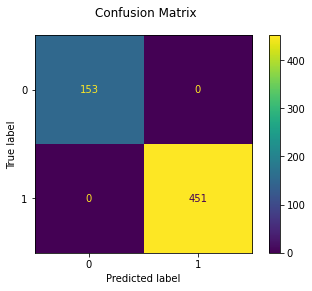

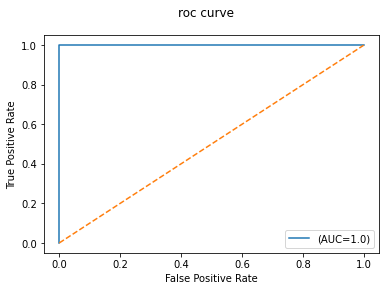

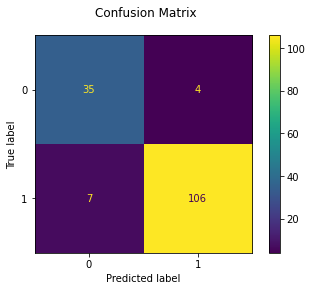

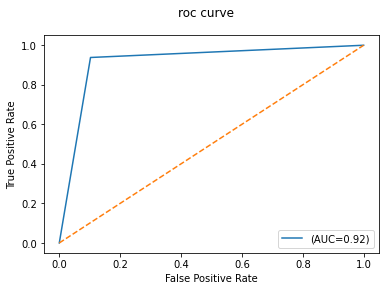

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

class ParzenClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, bandwidth=1.0, kernel='exponential'):
    self.bandwidth = bandwidth
    self.kernel = kernel
    self.models = []
    self.logpriors = []
    self.classes_ = None

  def fit(self, X_train, y_train):
    self.__init__(kernel=self.kernel)
    self.logpriors = []
    self.classes_ = np.unique(y_train)
    for c in self.classes_:
      X_train_c = X_train[y_train == c]
      print('using kernel', self.kernel)
      model = KernelDensity(bandwidth= self.bandwidth, kernel= self.kernel).fit(X_train_c)
      self.models.append(model)
      self.logpriors = np.log(len(X_train_c) / len(X_train))
  
  def predict_proba(self, X_test):
      logprobs = np.array([model.score_samples(X_test)
                            for model in self.models]).T
      
      result = np.exp(logprobs + self.logpriors)
      return result / result.sum(1, keepdims=True)
      
  def predict(self, X_test):
      return self.classes_[np.argmax(self.predict_proba(X_test), 1)]

  def score(self, X_test, y_test):
    return np.sum(clf.predict(X_test) == y_test)/len(y_test)


clf = ParzenClassifier()
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
clf = ParzenClassifier()
kfold_results(clf, X, y)

using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
Train set results: 

Mean Accuracy: 1.0,	 Accuracy Variance:0.0
Mean Recall: 1.0,	 Recall Variance:0.0
Mean Precision: 1.0,	 Precision Variance:0.0
Mean F1 Score: 1.0,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.9061,	 Accuracy Variance:0.0002
Mean Recall: 0.9061,	 Recall Variance:0.0002
Mean Precision: 0.9146,	 Precision Variance:0.0002
Mean F1 Score: 0.9103,	 F1 Score Variance:0.0002


### Parzen Classification Results
#### We can see that parzen classification has a great performance which is F1-score = 1 on train data and F1-score = 0.93 on test data. We tested different kernels for density estimation and finally we used exponential kernel which had the best performance. Also ROC curve for train data is perfect which indicates that this model has TPR=1 and FPR=0 (captures all positive samples and never predicts a negative sample as positive).  

# Discriminative Classifiers


## Logistic Regression
### Logistic regression is a linear model used to obtain the probability of data belonging to each class using a cost function and iteratively reducing the cost function value until reaching a desired loss. We have used Scikit-Learn implementation of the classifier and have obtained the following results on both test and training sets.

################################################
Accuracy for train set =  90.9 %
################################################
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       153
           1       0.92      0.96      0.94       451

    accuracy                           0.91       604
   macro avg       0.89      0.86      0.88       604
weighted avg       0.91      0.91      0.91       604

################################################
Confusion matrix:
[[118  35]
 [ 20 431]]
################################################
Accuracy for test set =  83.6 %
################################################
              precision    recall  f1-score   support

           0       0.69      0.64      0.67        39
           1       0.88      0.90      0.89       113

    accuracy                           0.84       152
   macro avg       0.79      0.77      0.78       152
weighted avg       0.83      0.84      0.83       

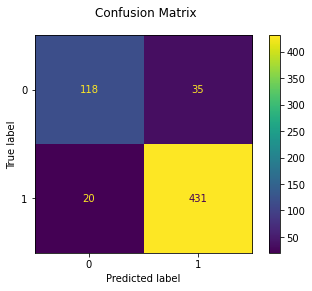

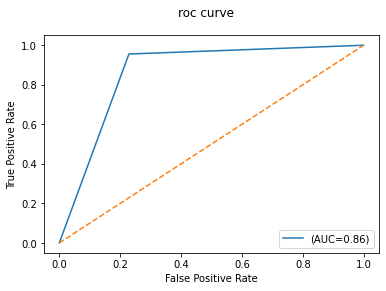

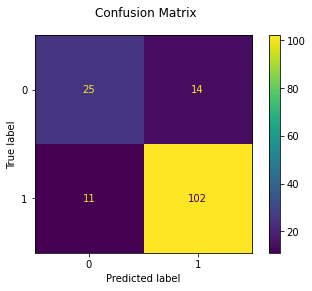

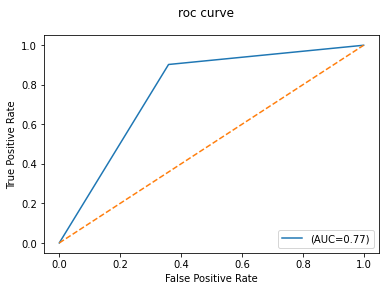

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

For a better understanding of the accuracy, precision and recall metrics we have implemented k-fold cross-validation and the results for logistic regression are as follows.

We have used a weighted average over precision and recall.
The variance for all of the metrics for the test set is significantly higher than that of the train set.

In [ ]:
kfold_results(clf, X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train set results: 

Mean Accuracy: 0.9117,	 Accuracy Variance:0.0001
Mean Recall: 0.961,	 Recall Variance:0.0001
Mean Precision: 0.9101,	 Precision Variance:0.0001
Mean F1 Score: 0.9109,	 F1 Score Variance:0.0001

#########################################

Test set results: 

Mean Accuracy: 0.8347,	 Accuracy Variance:0.0002
Mean Recall: 0.8347,	 Recall Variance:0.0002
Mean Precision: 0.8348,	 Precision Variance:0.0004
Mean F1 Score: 0.8347,	 F1 Score Variance:0.0003


### Logistic Regression Results
#### As expected, logistic regression is working better on the training set and still has an acceptable weighted average f1-score of 81 percents on the test set. 
 
#### The reason why logistic regression has acceptable performance on the data is probably because the data is linearly separable to a good degree however, logistic regression is not one of our best classifiers as we will see later in the article. We have also seen that KNN works better, since it can have unsmooth decision boundaries which can come in handy for a dataset like ours.


## Decision Tree

################################################
Accuracy for train set =  93.5 %
################################################
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       153
           1       0.92      1.00      0.96       451

    accuracy                           0.94       604
   macro avg       0.95      0.88      0.91       604
weighted avg       0.94      0.94      0.93       604

################################################
Confusion matrix:
[[116  37]
 [  2 449]]
################################################
Accuracy for test set =  76.3 %
################################################
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        39
           1       0.81      0.89      0.85       113

    accuracy                           0.76       152
   macro avg       0.68      0.64      0.65       152
weighted avg       0.74      0.76      0.75       

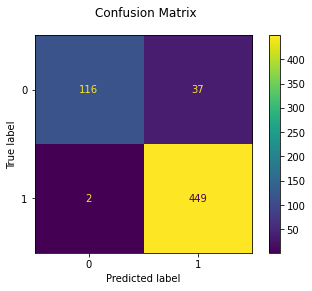

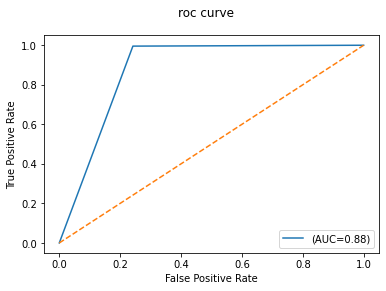

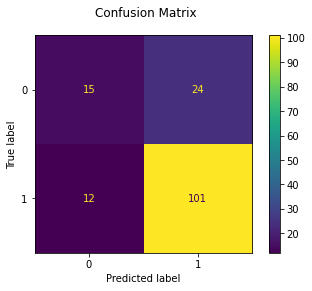

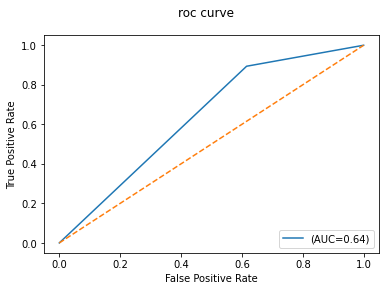

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth=6).fit(X_train, y_train)
decision_tree_pred = clf.predict(X_test)
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 0.9514,	 Accuracy Variance:0.0001
Mean Recall: 0.9787,	 Recall Variance:0.0001
Mean Precision: 0.9515,	 Precision Variance:0.0001
Mean F1 Score: 0.9514,	 F1 Score Variance:0.0001

#########################################

Test set results: 

Mean Accuracy: 0.7923,	 Accuracy Variance:0.0008
Mean Recall: 0.7923,	 Recall Variance:0.0008
Mean Precision: 0.7881,	 Precision Variance:0.0006
Mean F1 Score: 0.7902,	 F1 Score Variance:0.0007


### Decision Tree Results
#### As we can see above F1 Score for train set is 94% and for test set is 76% for test set also we can see that ROC curve for train data is much better than that of test data, so this model has performed well on train data but not on test data. This is because decision tree classifier is highly prone to overfitting and it has overfitted here.

## SVM

################################################
Accuracy for train set =  92.5 %
################################################
              precision    recall  f1-score   support

           0       0.90      0.80      0.84       153
           1       0.93      0.97      0.95       451

    accuracy                           0.93       604
   macro avg       0.92      0.88      0.90       604
weighted avg       0.92      0.93      0.92       604

################################################
Confusion matrix:
[[122  31]
 [ 14 437]]
################################################
Accuracy for test set =  79.6 %
################################################
              precision    recall  f1-score   support

           0       0.61      0.56      0.59        39
           1       0.85      0.88      0.86       113

    accuracy                           0.80       152
   macro avg       0.73      0.72      0.73       152
weighted avg       0.79      0.80      0.79       

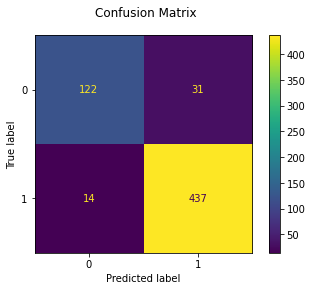

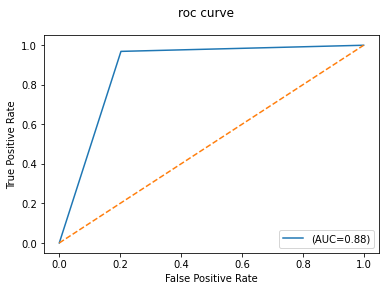

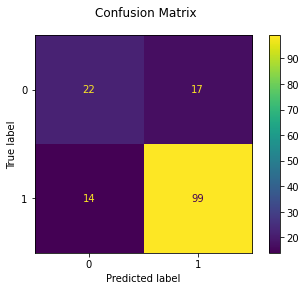

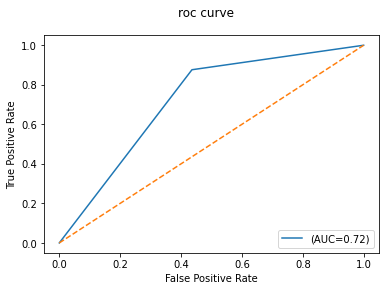

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 0.9196,	 Accuracy Variance:0.0
Mean Recall: 0.9672,	 Recall Variance:0.0
Mean Precision: 0.9187,	 Precision Variance:0.0001
Mean F1 Score: 0.9192,	 F1 Score Variance:0.0001

#########################################

Test set results: 

Mean Accuracy: 0.84,	 Accuracy Variance:0.0006
Mean Recall: 0.84,	 Recall Variance:0.0006
Mean Precision: 0.8411,	 Precision Variance:0.0005
Mean F1 Score: 0.8405,	 F1 Score Variance:0.0005


### SVM results
#### For the SVM kernel we experimented with all of the available kernels in the sklearn package and the best kernel was the linear kernel. SVM with a linear kernel works pretty good in terms of performance both for test and training set with F1 score of  93 percent for train set and 80 percent for test set.Since it will be linearly separating the classes the results are similar to that of Logistic Regression.


## KNN

################################################
Accuracy for train set =  95.9 %
################################################
              precision    recall  f1-score   support

           0       0.96      0.88      0.91       153
           1       0.96      0.99      0.97       451

    accuracy                           0.96       604
   macro avg       0.96      0.93      0.94       604
weighted avg       0.96      0.96      0.96       604

################################################
Confusion matrix:
[[134  19]
 [  6 445]]
################################################
Accuracy for test set =  89.5 %
################################################
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        39
           1       0.91      0.96      0.93       113

    accuracy                           0.89       152
   macro avg       0.88      0.84      0.85       152
weighted avg       0.89      0.89      0.89       

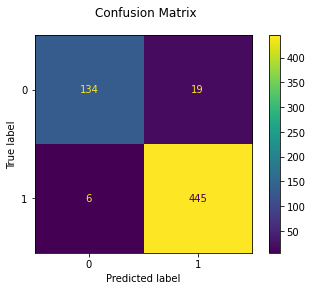

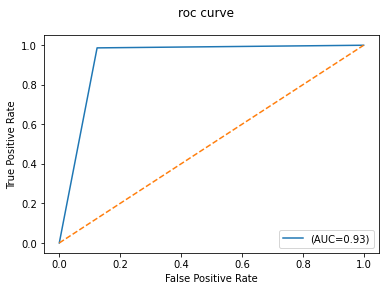

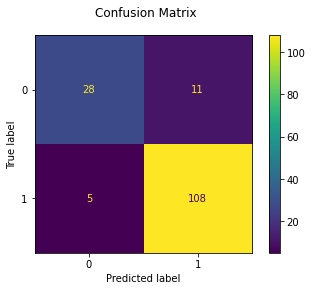

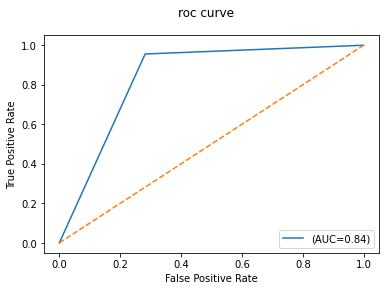

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 0.964,	 Accuracy Variance:0.0
Mean Recall: 0.9858,	 Recall Variance:0.0
Mean Precision: 0.9639,	 Precision Variance:0.0
Mean F1 Score: 0.9639,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.8836,	 Accuracy Variance:0.0001
Mean Recall: 0.8836,	 Recall Variance:0.0001
Mean Precision: 0.8842,	 Precision Variance:0.0001
Mean F1 Score: 0.8839,	 F1 Score Variance:0.0001


### KNN Results
#### We have already explained why the KNN classifier works well in the generative Models section. The KNN Classifier in the sklearn package works exactly like the one explained before and the result are identical.

## MLP
Multi-layer Perceptron Classifier is a neural network with relu activation function and a default 100 hidden layers. MLPClassifier trains iteratively since at each time step the partial derivatives of the loss function with respect to the model parameters are computed to update the parameters.

################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  84.2 %
################################################
              precision    recall  f1-score   support

           0       0.71      0.64      0.68        39
           1       0.88      0.91      0.90       113

    accuracy                           0.84       152
   macro avg       0.80      0.78      0.79       152
weighted avg       0.84      0.84      0.84      

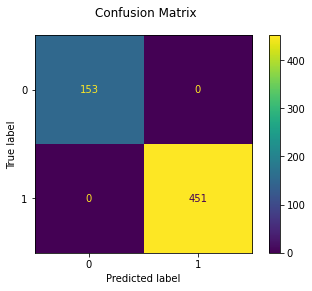

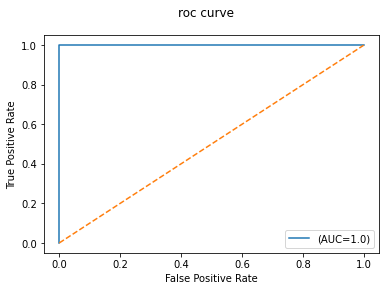

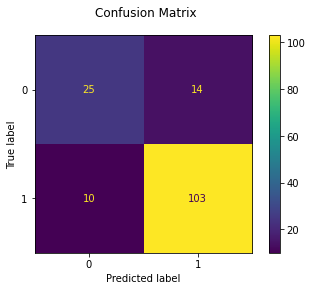

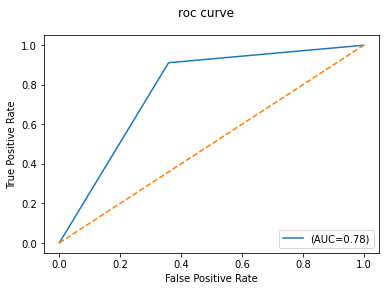

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=3000)
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 1.0,	 Accuracy Variance:0.0
Mean Recall: 1.0,	 Recall Variance:0.0
Mean Precision: 1.0,	 Precision Variance:0.0
Mean F1 Score: 1.0,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.881,	 Accuracy Variance:0.0006
Mean Recall: 0.881,	 Recall Variance:0.0006
Mean Precision: 0.881,	 Precision Variance:0.0006
Mean F1 Score: 0.881,	 F1 Score Variance:0.0006


The MLP Classifier has a perfect performance on the trainset however it does not perform equally as good on the test set as it has probably overfitted to the train data. However, overall the MLP Classifier does have an acceptable F1 score of 82 percent on the single split data and 87 on the 5-fold split.

## RBF

################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  90.1 %
################################################
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        39
           1       0.93      0.94      0.93       113

    accuracy                           0.90       152
   macro avg       0.87      0.87      0.87       152
weighted avg       0.90      0.90      0.90      

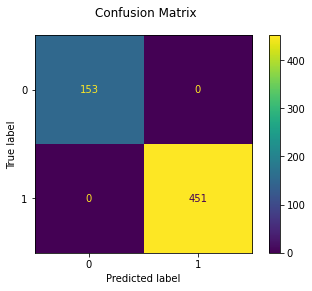

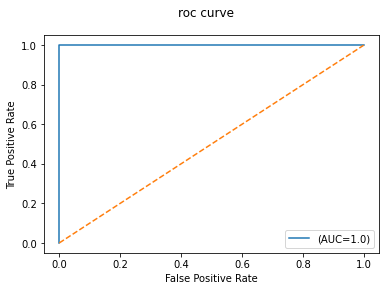

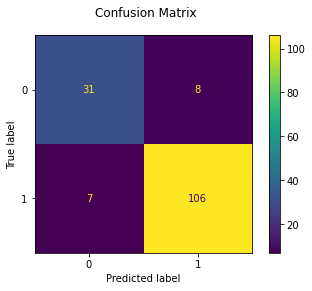

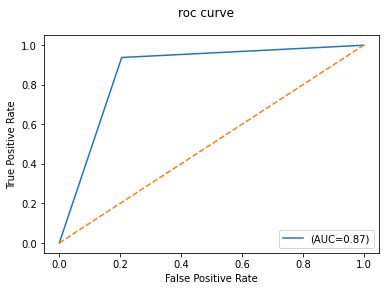

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
clf = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 1.0,	 Accuracy Variance:0.0
Mean Recall: 1.0,	 Recall Variance:0.0
Mean Precision: 1.0,	 Precision Variance:0.0
Mean F1 Score: 1.0,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.8968,	 Accuracy Variance:0.0003
Mean Recall: 0.8968,	 Recall Variance:0.0003
Mean Precision: 0.9009,	 Precision Variance:0.0003
Mean F1 Score: 0.8988,	 F1 Score Variance:0.0003


## RBF results:
#### RBF is more time-consuming that all classifiers. It uses Radial Basis kernel function. As it can be seen above, it has perfect accuracy and F1-score on train dataset and about 90% accuracy and F1 score on test dataset which is relatively good. Also the area under curve is good for this classifier. 

# Ensemble Methods

### **Why is using ensemble methods useful?**

#### Ensemble methods have three important advantages. The can improve **Robustnes**, **Performance** and the **bias varince trade-off**.

####1. **Robustnes**: When we are using a single model on our data, we can use k-fold cross-validation to get a general idea about the average accuracy of the model. However the average performance might not be enough. One simple ensemble method is to fit the model multiple times on the dataset and combine the predictions.
This way the spread in the prediction reduces and although mean of the performance might not change much, but the best and worst case performances get closer to the mean performance thus the the expected performance of the model smoothes out and model becomes more robust. 

####2. **Bias, Variance**: When learning a model we want to minimize the bias and the variance, howver these two cannot be done together, hence the bias, vairance trade-off. When we use ensemble methods variance of the predictions reduces, meaning the amount of error in the predictions that can be attributed to variance.

####3. **Performance**: When variance in the prediction error is reduced the performance improves. However, the ensemble method might not work as good as the best-performing classifier/regressor member, at those times using the single classifier by its own is better. This can happen when the performance of the best-performing classifier is worsened by the worst-performing classifier.

###**What is Boosting?**

#### Ensemble methods use a set of learners to achieve a better performance than the single learners.

####**Bootstrap Aggregation** or Bagging is an ensemble method. Bootstrapping itself means generating samples of size B from and initial dataset of size N by randomly drawing with replacement (meaning we can select the same value multiple times) B observations. Now if we want to have an estimate of for example mean or variance of the wole data we can calculate the mean or variance of each subsample and report the average mean or variance with a confidence interval.

####Bagging is when we fit several independant models and average their predictions to obtain a model variance. In practice however we cannot obtain fully independent models as it would require a lot of data. So we create multiple bootstrap samples in a way that each sample will act as another almost independent dataset drawn from the true distribution, then for each of the samples a weak learner is fitted and finally the result is the aggregation of all of the weak samples. We want this aggregation somewhat average the outputs of the single models. There are multiple ways of Bagging such as Hard-Voting, Soft-Voting and Random Forests.



## Bagging Method

#### As mentioned above bagging uses an aggregation over the boostrapped samples. The aggregation can be either voting or averaging. In the <code>BaggingClassifier</code> implemented by sklearn if the model support <code>predict_proba</code> the result of the ensemble classifier is the mean predicted probabilities of the base estimators, otherwise it resorts to voting. We are going to implement bagging for different classifiers we have already used in hopes of obtainig classifiers with better performances.

#### We are going to use bagging for the best classifiers we have obtained yet to observe the changes.



### KNN

################################################
Accuracy for train set =  95.4 %
################################################
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       153
           1       0.95      0.98      0.97       451

    accuracy                           0.95       604
   macro avg       0.95      0.92      0.94       604
weighted avg       0.95      0.95      0.95       604

################################################
Confusion matrix:
[[132  21]
 [  7 444]]
################################################
Accuracy for test set =  90.1 %
################################################
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        39
           1       0.92      0.95      0.93       113

    accuracy                           0.90       152
   macro avg       0.88      0.86      0.87       152
weighted avg       0.90      0.90      0.90       

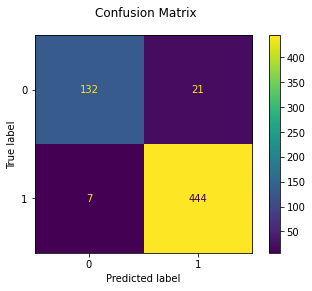

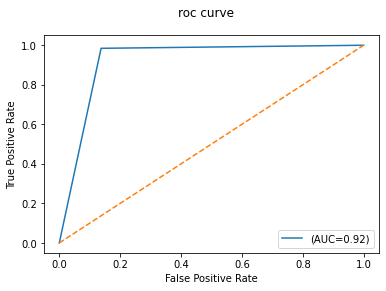

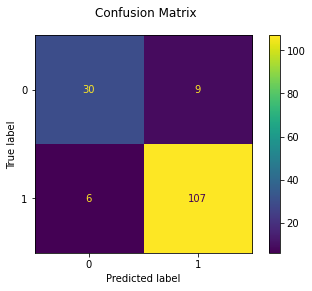

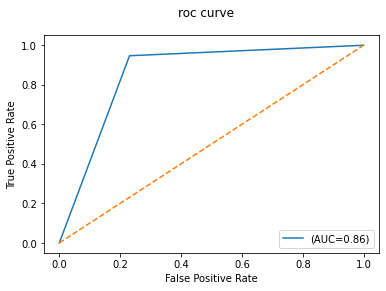

In [ ]:
from sklearn.ensemble import BaggingClassifier

base_estimator = KNeighborsClassifier(n_neighbors=3)

clf = BaggingClassifier(base_estimator=base_estimator,
      n_estimators=10, random_state=0).fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 0.9587,	 Accuracy Variance:0.0
Mean Recall: 0.9871,	 Recall Variance:0.0
Mean Precision: 0.9588,	 Precision Variance:0.0
Mean F1 Score: 0.9587,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.881,	 Accuracy Variance:0.0001
Mean Recall: 0.881,	 Recall Variance:0.0001
Mean Precision: 0.8817,	 Precision Variance:0.0001
Mean F1 Score: 0.8813,	 F1 Score Variance:0.0001


### Bagging KNN Results

#### The results show that using bagging on the KNN classifier does not improve the performance much, in fact the F1 score has dropped 1 percent. This is not a big difference however and the reason for it can be because all of the KNN models used and all of the data that they were used on were quite similar and we know that bagging is designed to reduce the effects of the worst single classifier and overall bring the whole performance closer to the average performance. 

### MLP

################################################
Accuracy for train set =  99.3 %
################################################
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       153
           1       0.99      1.00      1.00       451

    accuracy                           0.99       604
   macro avg       0.99      0.99      0.99       604
weighted avg       0.99      0.99      0.99       604

################################################
Confusion matrix:
[[150   3]
 [  1 450]]
################################################
Accuracy for test set =  83.6 %
################################################
              precision    recall  f1-score   support

           0       0.75      0.54      0.63        39
           1       0.85      0.94      0.89       113

    accuracy                           0.84       152
   macro avg       0.80      0.74      0.76       152
weighted avg       0.83      0.84      0.83       

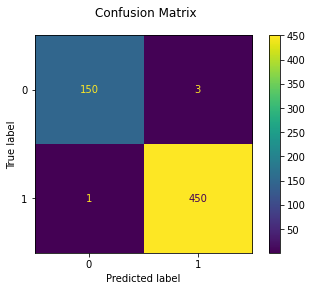

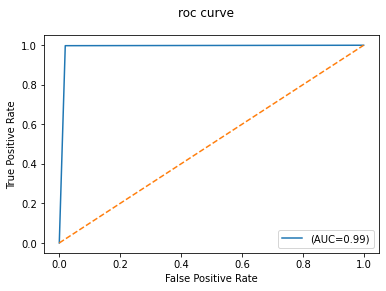

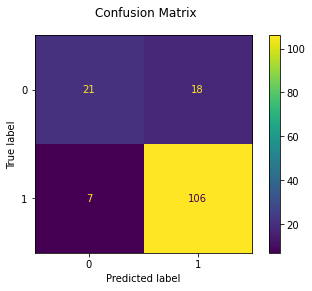

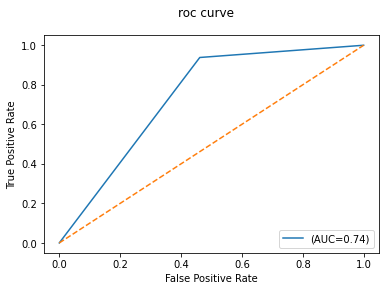

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

base_estimator = MLPClassifier(random_state=1, max_iter=300)

clf = BaggingClassifier(base_estimator=base_estimator,
      n_estimators=10, random_state=1).fit(X_train, y_train)

report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 0.9914,	 Accuracy Variance:0.0
Mean Recall: 0.996,	 Recall Variance:0.0
Mean Precision: 0.9914,	 Precision Variance:0.0
Mean F1 Score: 0.9914,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.881,	 Accuracy Variance:0.0007
Mean Recall: 0.881,	 Recall Variance:0.0007
Mean Precision: 0.884,	 Precision Variance:0.0006
Mean F1 Score: 0.8825,	 F1 Score Variance:0.0007


### Bagging MLP Results
 
#### Like KNN this bagging method also did not make a big improvement on the performance of the model. The F1 score for the single data split was 82 percent; the same metric for this model is 85 percent which shows a slight improvement. For the 5-folded result, the single classifier reaches 87 percent in F1 score and the ensemble model reaches 88 percent which is only slightly better. The reason for this is also like what was for KNN Bagged model.


### Random Forest

################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  84.2 %
################################################
              precision    recall  f1-score   support

           0       0.89      0.44      0.59        39
           1       0.83      0.98      0.90       113

    accuracy                           0.84       152
   macro avg       0.86      0.71      0.74       152
weighted avg       0.85      0.84      0.82      

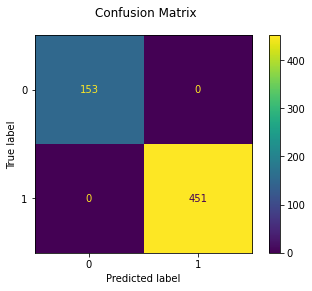

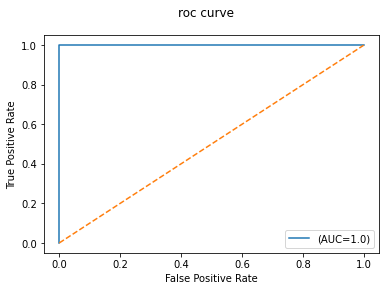

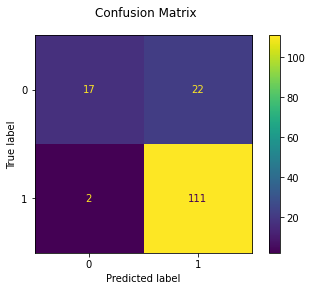

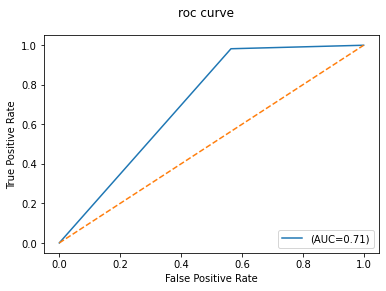

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 1.0,	 Accuracy Variance:0.0
Mean Recall: 1.0,	 Recall Variance:0.0
Mean Precision: 1.0,	 Precision Variance:0.0
Mean F1 Score: 1.0,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.8307,	 Accuracy Variance:0.0002
Mean Recall: 0.8307,	 Recall Variance:0.0002
Mean Precision: 0.843,	 Precision Variance:0.0005
Mean F1 Score: 0.8367,	 F1 Score Variance:0.0003


### Random Forest Results
 
#### Random Forest is a bagging method where the models aggregated are decision trees. Since we have multiple decision trees we can say we have a forest :).
#### Random Forest on a single split worked much better than a single Decision Tree, improving the F1 score around 7 percents. This could be because each tree sees a different sample of the data each tree has a different decision boundary and as the number of the trees grows the decision boundary becomes more accurate. The 5-folded F1 scores also have improved for the Random Forest.


### Parzen Window Classifier

using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
################################################
Accuracy for train set =  99.5 %
################################################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       153
           1       1.00      0.99      1.00       451

    accuracy                           1.00       604
   macro avg       0.99      1.00      0.99       604
weighted avg       1.00      1.00      1.00       604

##########################################

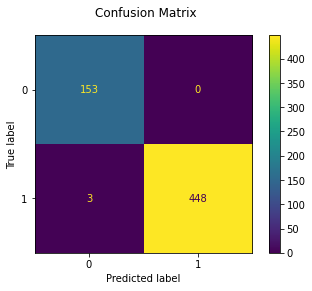

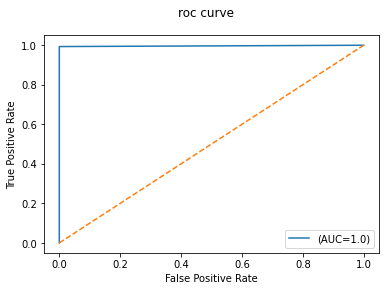

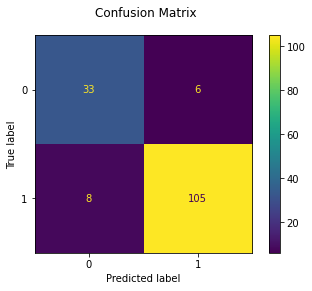

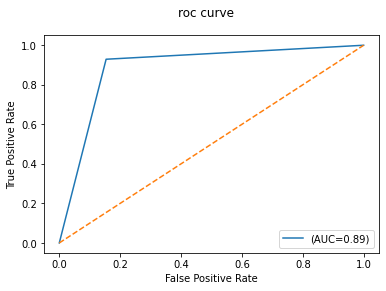

In [ ]:
from sklearn.ensemble import BaggingClassifier

base_estimator = ParzenClassifier()

clf = BaggingClassifier(base_estimator=base_estimator,
      n_estimators=10, random_state=1).fit(X_train, y_train)
      
report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential
using kernel exponential


### Parzen Window Classifier 
#### The results for bagging on Parzen Window Density estimation with bayesian decision are similar to the single classifier and the reason for it could also be similar to the classifiers above meaning the single classifiers are similar in performance so the overall performance does not change a lot.

## Voting
Voting is a bagging method. **Hard Voting** is where a model is selected from an ensemble to make the final prediction by a simple majority vote for accuracy.

**Soft Voting** can only be done when all your classifiers can calculate probabilities for the outcomes. Soft voting arrives at the best result by averaging out the probabilities calculated by individual algorithms.

The BaggingClassifier uses soft voting when the classifier implements the <code>predict_proba</code> function, otherwise it uses hard voting.
We have implemented both here for a better observation.

Also when using the <code>VotingClassifier</code> we do not need for the models to all be the same kind. Here KNN, MLP and Random Forest are the base estimators used.

################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  86.8 %
################################################
              precision    recall  f1-score   support

           0       0.85      0.59      0.70        39
           1       0.87      0.96      0.92       113

    accuracy                           0.87       152
   macro avg       0.86      0.78      0.81       152
weighted avg       0.87      0.87      0.86      

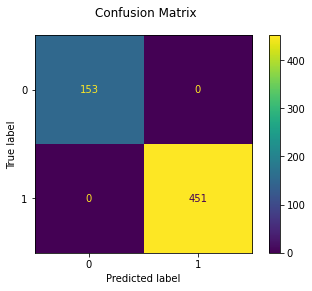

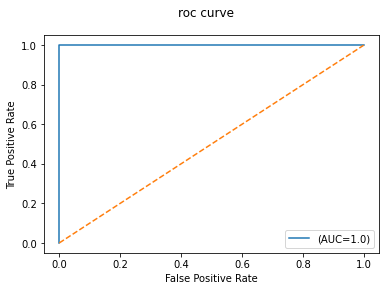

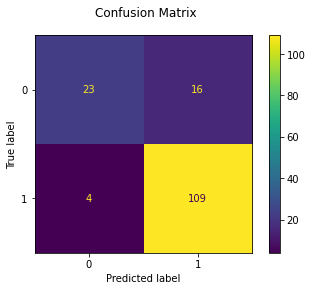

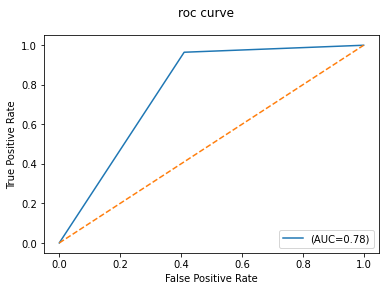

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = MLPClassifier(random_state=1, max_iter=3000)
clf3 = RandomForestClassifier(random_state=0)

eclf = VotingClassifier(estimators=[('knn', clf1), ('mlp', clf2), ('rf', clf3)], voting='hard')
eclf.fit(X_train, y_train)
report_results(eclf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(eclf, X, y)

Train set results: 

Mean Accuracy: 1.0,	 Accuracy Variance:0.0
Mean Recall: 1.0,	 Recall Variance:0.0
Mean Precision: 1.0,	 Precision Variance:0.0
Mean F1 Score: 1.0,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.8849,	 Accuracy Variance:0.0004
Mean Recall: 0.8849,	 Recall Variance:0.0004
Mean Precision: 0.8888,	 Precision Variance:0.0003
Mean F1 Score: 0.8868,	 F1 Score Variance:0.0003


### Hard Voting Result

#### As we can see above the performance of the voting classifier is almost the average of all of the single working classifiers which is not unexpected.

################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  86.8 %
################################################
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        39
           1       0.88      0.96      0.92       113

    accuracy                           0.87       152
   macro avg       0.85      0.79      0.81       152
weighted avg       0.87      0.87      0.86      

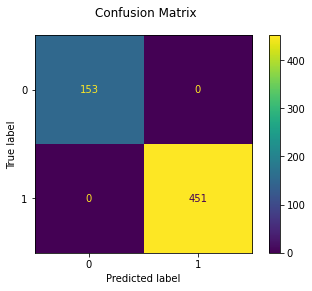

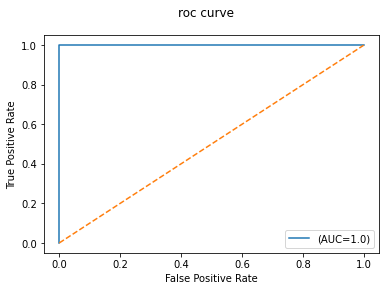

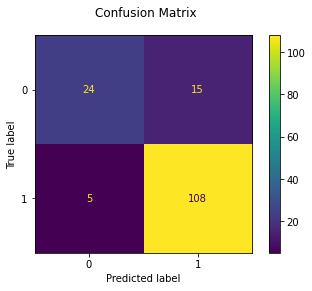

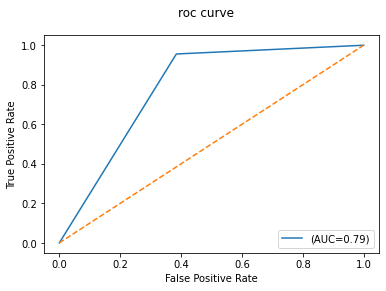

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = MLPClassifier(random_state=1, max_iter=3000)
clf3 = RandomForestClassifier(random_state=0)

eclf = VotingClassifier(estimators=[('knn', clf1), ('mlp', clf2), ('rf', clf3)], voting='soft')
eclf.fit(X_train, y_train)
report_results(eclf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(eclf, X, y)

Train set results: 

Mean Accuracy: 1.0,	 Accuracy Variance:0.0
Mean Recall: 1.0,	 Recall Variance:0.0
Mean Precision: 1.0,	 Precision Variance:0.0
Mean F1 Score: 1.0,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.8889,	 Accuracy Variance:0.0004
Mean Recall: 0.8889,	 Recall Variance:0.0004
Mean Precision: 0.891,	 Precision Variance:0.0003
Mean F1 Score: 0.8899,	 F1 Score Variance:0.0004


### Soft Voting Results
#### The soft voting results are almost identical to the hard voting results this is both because the base classifiers are close in performance and also some of them do not implement <code>predict_proba</code> function.

## Boosting Method
 
#### Boosting methods work in a similar way to Bagging methods, however, unlike bagging that mainly aims at reducing variance, boosting is a technique that consists in fitting sequentially multiple weak learners in a very adaptative way: each model in the sequence is fitted giving more importance to observations in the dataset that were badly handled by the previous models in the sequence. Intuitively, each new model focuses its efforts on the most difficult observations to fit up to now, so that we obtain, at the end of the process, a strong learner with lower bias. Being mainly focused at reducing bias, the base models that are often considered for boosting are models with low variance but high bias. 
 
#### The sklearn <code>AdaBoost</code> is a Boosting method that uses weak classifiers and uses boosting to reach a better classifier. We have used this classifier for logistic regression as well as a shallow (depth = 1) decision tree.


### AdaBoost

#### Logistic Regression

################################################
Accuracy for train set =  89.6 %
################################################
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       153
           1       0.92      0.94      0.93       451

    accuracy                           0.90       604
   macro avg       0.87      0.85      0.86       604
weighted avg       0.89      0.90      0.89       604

################################################
Confusion matrix:
[[117  36]
 [ 27 424]]
################################################
Accuracy for test set =  84.9 %
################################################
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        39
           1       0.89      0.91      0.90       113

    accuracy                           0.85       152
   macro avg       0.81      0.79      0.80       152
weighted avg       0.85      0.85      0.85       

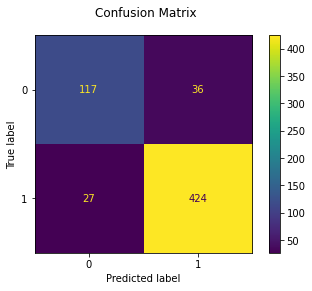

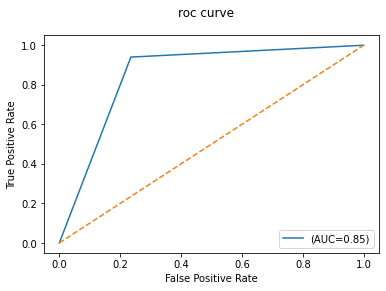

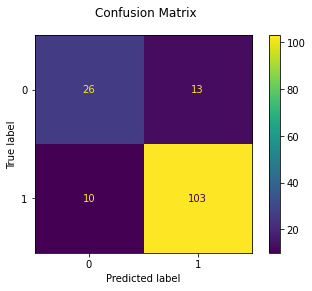

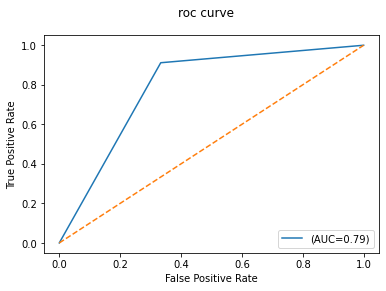

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


base_estimator = LogisticRegression(random_state=0)
clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 0.8899,	 Accuracy Variance:0.0001
Mean Recall: 0.9433,	 Recall Variance:0.0001
Mean Precision: 0.8876,	 Precision Variance:0.0002
Mean F1 Score: 0.8888,	 F1 Score Variance:0.0002

#########################################

Test set results: 

Mean Accuracy: 0.8294,	 Accuracy Variance:0.0018
Mean Recall: 0.8294,	 Recall Variance:0.0018
Mean Precision: 0.8309,	 Precision Variance:0.0011
Mean F1 Score: 0.8301,	 F1 Score Variance:0.0014


#### Decision Tree

################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  80.3 %
################################################
              precision    recall  f1-score   support

           0       0.62      0.59      0.61        39
           1       0.86      0.88      0.87       113

    accuracy                           0.80       152
   macro avg       0.74      0.73      0.74       152
weighted avg       0.80      0.80      0.80      

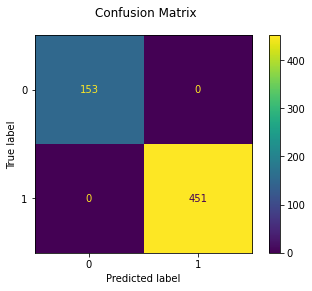

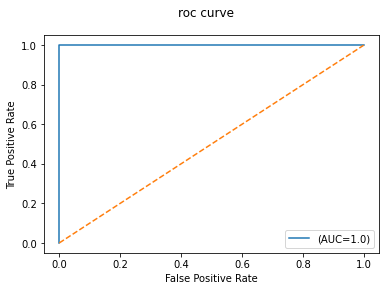

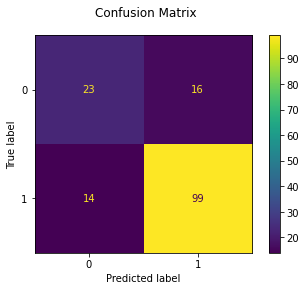

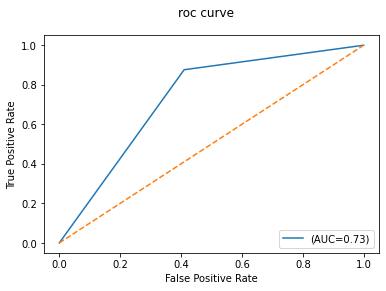

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(random_state=0, max_depth=1)
clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

report_results(clf, X_train, y_train, X_test, y_test)

In [ ]:
kfold_results(clf, X, y)

Train set results: 

Mean Accuracy: 0.9993,	 Accuracy Variance:0.0
Mean Recall: 0.9996,	 Recall Variance:0.0
Mean Precision: 0.9993,	 Precision Variance:0.0
Mean F1 Score: 0.9993,	 F1 Score Variance:0.0

#########################################

Test set results: 

Mean Accuracy: 0.8188,	 Accuracy Variance:0.0009
Mean Recall: 0.8188,	 Recall Variance:0.0009
Mean Precision: 0.8164,	 Precision Variance:0.0009
Mean F1 Score: 0.8176,	 F1 Score Variance:0.0009


### Boosting Results
#### As can be observed above the boosting method has improved the performances of both of the weaker classifiers (Logistic Regression and Decision Tree with a very small depth). The F1 Score of the test set for both of these classifiers has increased around 5 percents and the area under the ROC curve has also gotten larger as we would expect.


# **The Best Classifier : Parzen Window with Bayesian Decision**
#### We used F1-Score metric for evaluations and comparisons
#### It had reasonablly fast execution time

# **The Worst Classifier : Decision Tree**
#### Becuase of the overfitting issue

# Tuning Hyperparameters:
#### We used F1-score metric to chose this model. Now we want to tune this model:

using kernel gaussian
using kernel gaussian
################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  71.1 %
################################################
              precision    recall  f1-score   support

           0       0.44      0.49      0.46        39
           1       0.82      0.79      0.80       113

    accuracy                           0.71       152
   macro avg       0.63      0.64      0.63       152
weigh

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


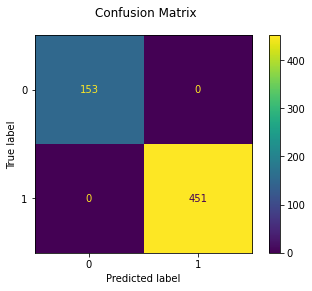

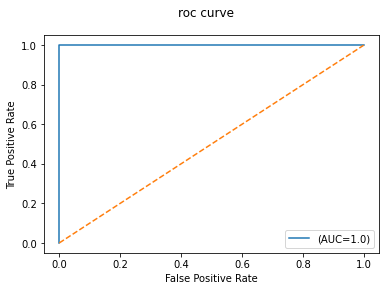

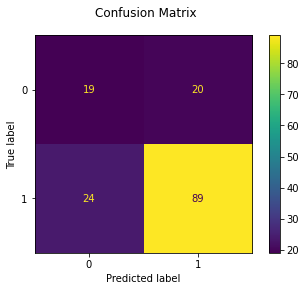

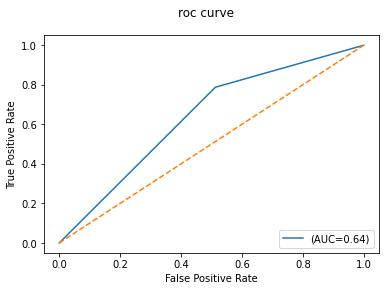

In [ ]:
clf = ParzenClassifier(kernel='gaussian')
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

using kernel tophat
using kernel tophat
################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  25.7 %
################################################
              precision    recall  f1-score   support

           0       0.26      1.00      0.41        39
           1       0.00      0.00      0.00       113

    accuracy                           0.26       152
   macro avg       0.13      0.50      0.20       152
weighted 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Confusion matrix:
[[ 39   0]
 [113   0]]


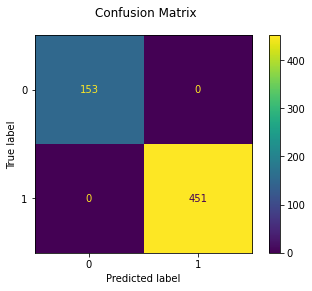

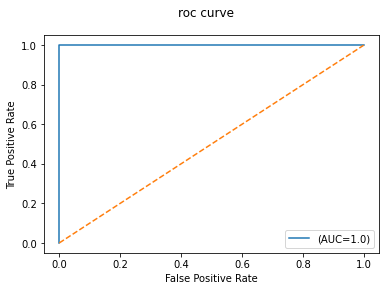

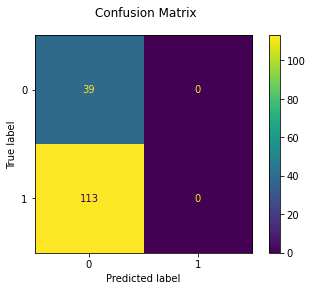

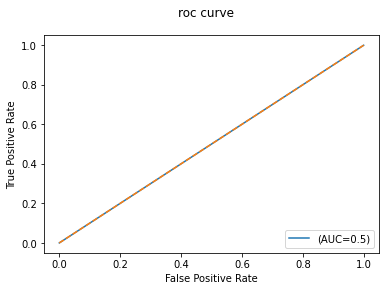

In [ ]:
clf = ParzenClassifier(kernel='tophat')
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

using kernel epanechnikov
using kernel epanechnikov
################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  38.8 %
################################################
              precision    recall  f1-score   support

           0       0.27      0.79      0.40        39
           1       0.78      0.25      0.38       113

    accuracy                           0.39       152
   macro avg       0.52      0.52      0.39       1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


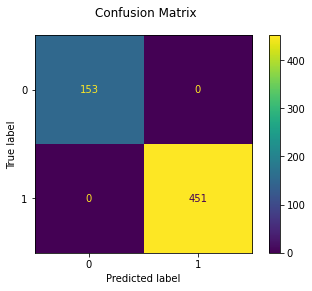

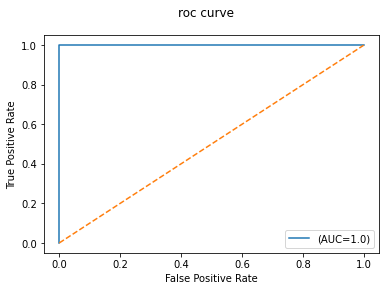

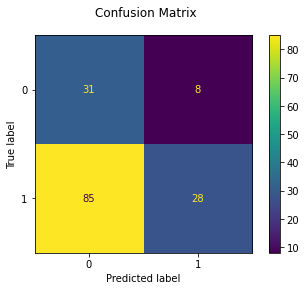

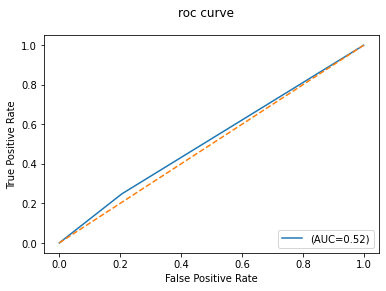

In [ ]:
clf = ParzenClassifier(kernel='epanechnikov')
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

using kernel exponential
using kernel exponential
################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  92.8 %
################################################
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        39
           1       0.96      0.94      0.95       113

    accuracy                           0.93       152
   macro avg       0.90      0.92      0.91       152

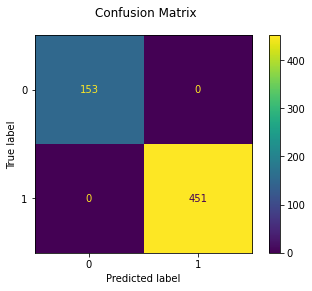

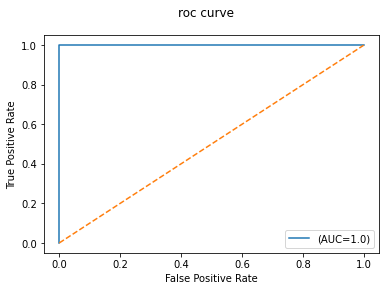

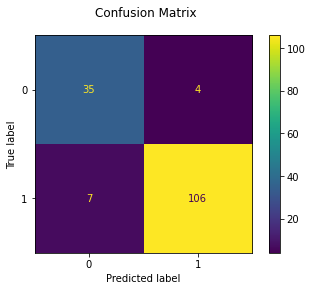

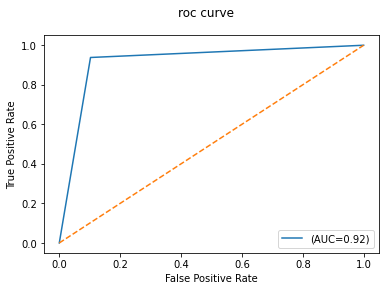

In [ ]:
clf = ParzenClassifier(kernel='exponential')
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

using kernel linear
using kernel linear
################################################
Accuracy for train set =  100.0 %
################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       451

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604

################################################
Confusion matrix:
[[153   0]
 [  0 451]]
################################################
Accuracy for test set =  40.8 %
################################################
              precision    recall  f1-score   support

           0       0.28      0.85      0.42        39
           1       0.83      0.26      0.39       113

    accuracy                           0.41       152
   macro avg       0.56      0.55      0.41       152
weighted 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


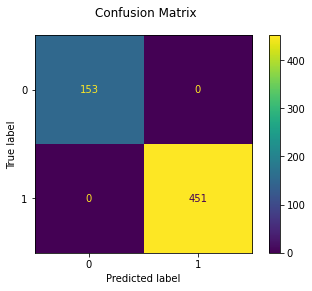

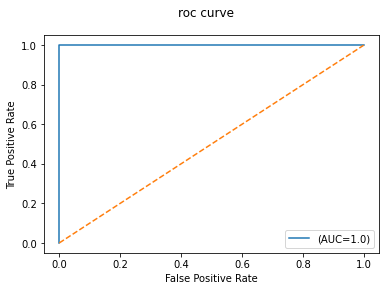

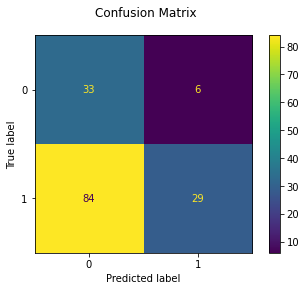

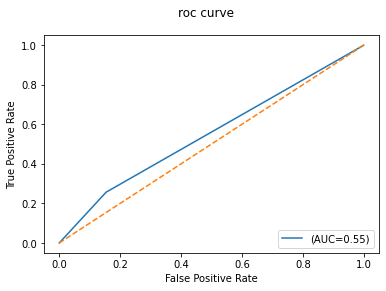

In [ ]:
clf = ParzenClassifier(kernel='linear')
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

using kernel cosine
using kernel cosine
################################################
Accuracy for train set =  25.3 %
################################################
              precision    recall  f1-score   support

           0       0.25      1.00      0.40       153
           1       0.00      0.00      0.00       451

    accuracy                           0.25       604
   macro avg       0.13      0.50      0.20       604
weighted avg       0.06      0.25      0.10       604

################################################


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[153   0]
 [451   0]]
################################################
Accuracy for test set =  25.7 %
################################################
              precision    recall  f1-score   support

           0       0.26      1.00      0.41        39
           1       0.00      0.00      0.00       113

    accuracy                           0.26       152
   macro avg       0.13      0.50      0.20       152
weighted avg       0.07      0.26      0.10       152

################################################
Confusion matrix:
[[ 39   0]
 [113   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


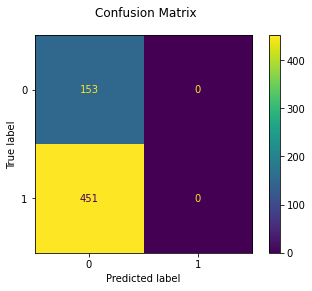

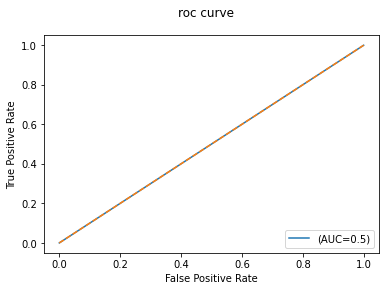

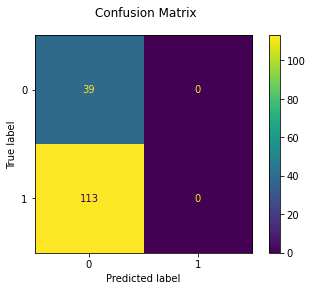

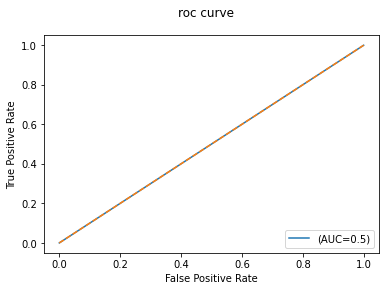

In [ ]:
clf = ParzenClassifier(kernel='cosine')
clf.fit(X_train, y_train)
report_results(clf, X_train, y_train, X_test, y_test)

## Result of Tunning: Exponential kernel has best performance for parzen window density estimation.  